In [1]:
!pip install wandb
!pip install lightning
# from google.colab import drive
# drive.mount('/content/drive')


cpu


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


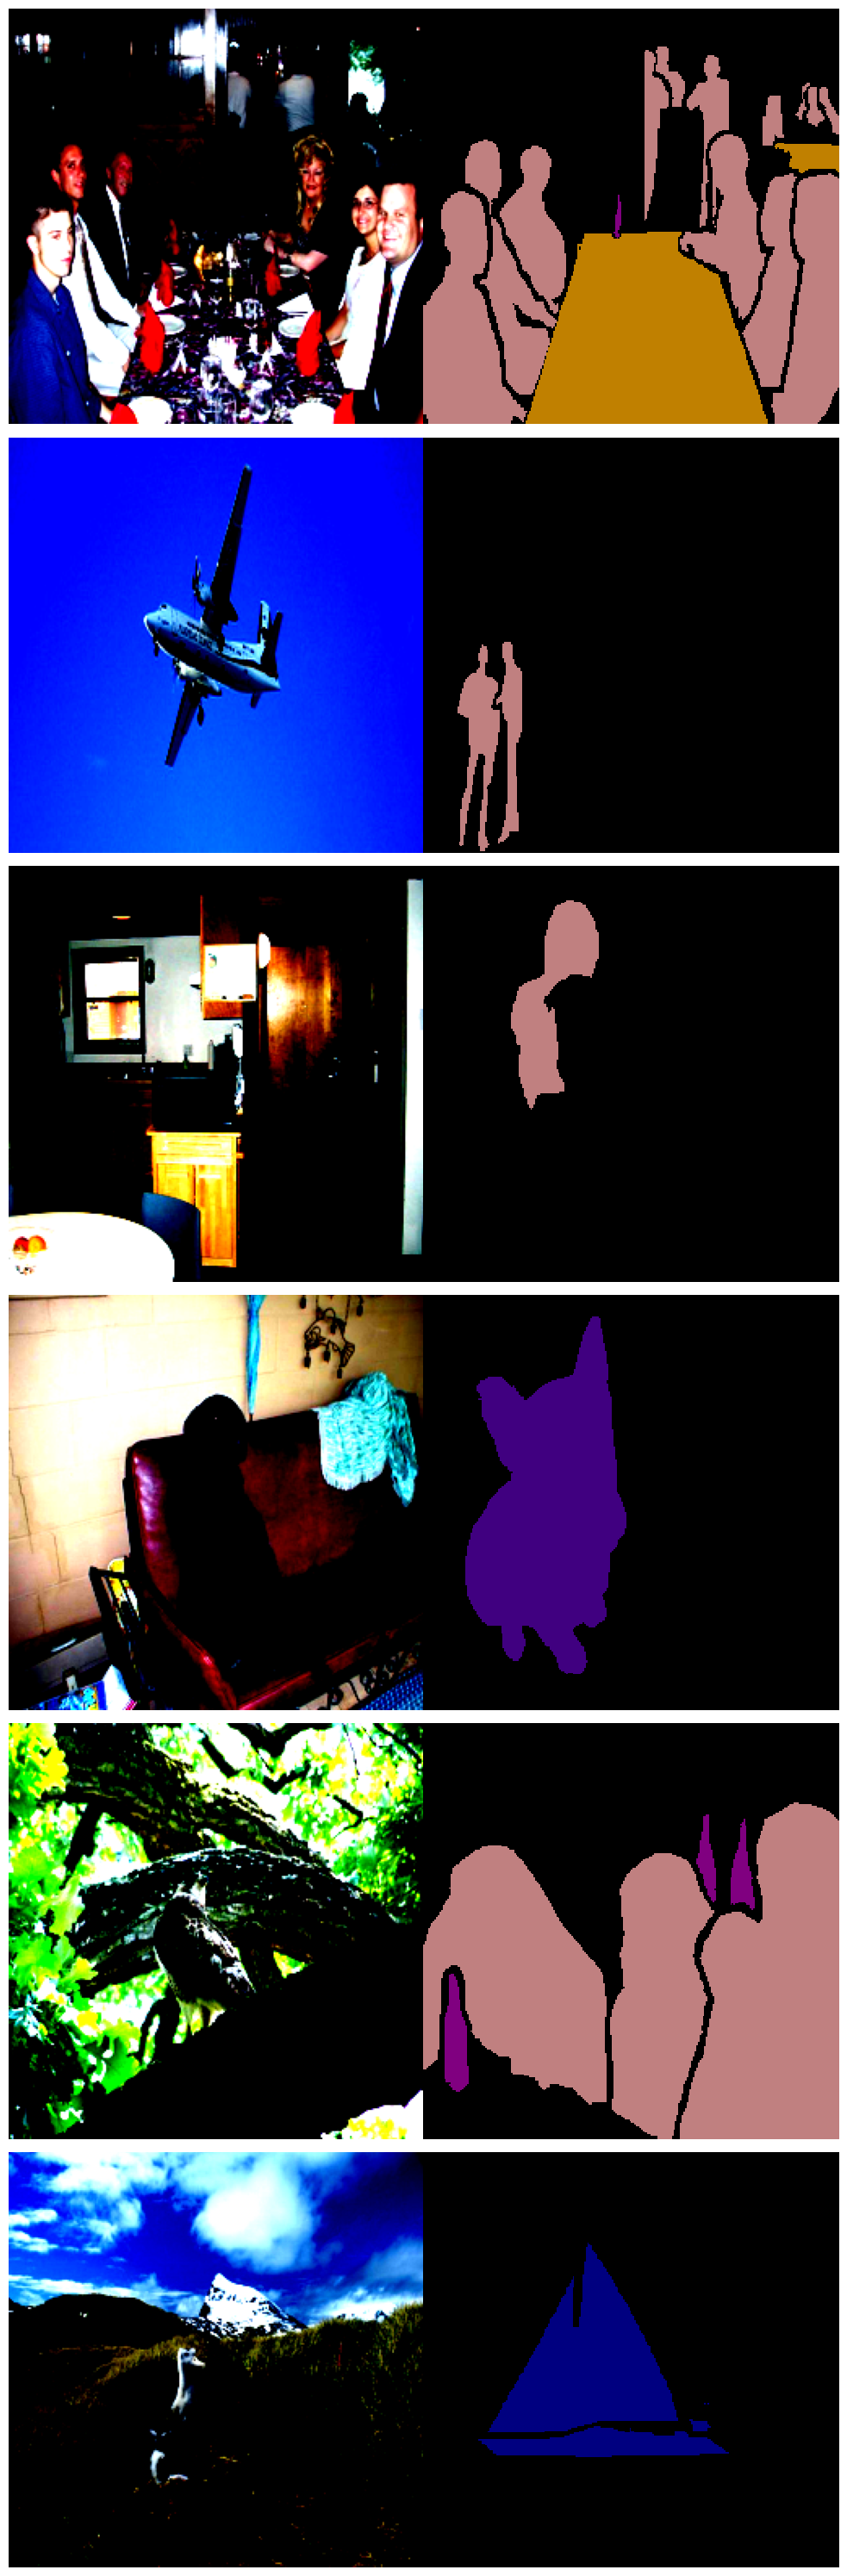

/Users/maryamsoftdev/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maryamsoftdev/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/maryamsoftdev/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|█████████████████████████████████████████| 528M/528M [10:19<00:00, 894kB/s]
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU a

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/maryamsoftdev/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 16 but got size 32 for tensor number 1 in the list.

In [3]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
import torch.optim as optim
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as pl
import torchmetrics

# Set up the WandbLogger
wandb_logger = WandbLogger(log_model="all", project="VOCSegmentation", name='exp1')

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Define constants and color mappings
ALL_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 
    'chair', 'cow', 'dining table', 'dog', 'horse', 'motorbike', 'person', 'potted plant', 
    'sheep', 'sofa', 'train', 'tv/monitor'
]
LABEL_COLORS_LIST = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128],
    [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
    [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128], [0, 64, 0], [128, 64, 0],
    [0, 192, 0], [128, 192, 0], [0, 64, 128]
]
jaccard = torchmetrics.JaccardIndex(task="multiclass",num_classes=len(ALL_CLASSES)).to(device)

normalized_colors = [[r/255, g/255, b/255] for r, g, b in LABEL_COLORS_LIST]
cmap = ListedColormap(normalized_colors)

# Dataset and DataLoader setup
class VOCDataSet(Dataset):
    
    def __init__(self, root_dir, dataset_type='train', transform=None):
        self.root_dir = root_dir
        self.transform = transform

        if dataset_type == 'train':
            self.image_folder = os.path.join(root_dir, 'train_images')
            self.label_folder = os.path.join(root_dir, 'train_labels')
        elif dataset_type == 'val':
            self.image_folder = os.path.join(root_dir, 'valid_images')
            self.label_folder = os.path.join(root_dir, 'valid_labels')
        else:
            raise ValueError("Invalid dataset_type. Use 'train' or 'val'.")

        self.image_list = os.listdir(self.image_folder)
        self.label_list = os.listdir(self.label_folder)

    # Convert RGB label to an integer label
    def rgb_to_integer(self,label_rgb):
        label_integer = np.zeros(label_rgb.shape[:2], dtype=np.uint8)
        for i, color in enumerate(LABEL_COLORS_LIST):
            mask = np.all(label_rgb == color, axis=-1)
            label_integer[mask] = i
        return label_integer

    def __len__(self):
        return len(self.image_list)

    #read image and mask for a single image and apply transform 
    #be careful with applying transformations on the Mask (it should remain integer)
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_list[idx])
        label_name = os.path.join(self.label_folder, self.label_list[idx])
        image = Image.open(img_name)
        label = Image.open(label_name).convert('RGB')      
        label_array = np.array(label)
        label_integer = self.rgb_to_integer(label_array)      
        
        if self.transform:
            image = self.transform(image)         
            
        imSize = self.transform.transforms[0].size[0]
        label_integer=(torch.tensor(label_integer).unsqueeze(0)).unsqueeze(0)
        label_integer = F.interpolate(label_integer, size=(imSize,imSize), mode='nearest').squeeze(0).squeeze(0).long() #only use NN
               
        return image, label_integer


# Define the transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a train dataset object
train_dataset = VOCDataSet(root_dir='voc_2012_segmentation_data', dataset_type='train', transform=transform)
# Create a DataLoader for the train dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create a validation dataset object
val_dataset = VOCDataSet(root_dir='voc_2012_segmentation_data', dataset_type='val', transform=transform)
# Create a DataLoader for the train dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Get a batch of data & display it (just to see we correctly read the dataset!)
images, masks = next(iter(train_loader))
# Display the batch
fig, axs = plt.subplots(6, 2, figsize=(10, 30))
for i in range(6):
    # Display image
    axs[i, 0].imshow(images[i].permute(1, 2, 0))
    axs[i, 0].axis('off')    
    #use NN to display exact
    axs[i, 1].imshow(np.squeeze(masks[i]),cmap=cmap,interpolation='nearest',vmin=0, vmax=len(ALL_CLASSES)-1)
    axs[i, 1].axis('off')
    #axs[i, 1].set_title('Mask')
plt.tight_layout()
plt.show(block=True)

# Define the ResNet based U-Net model
class VOCVGGUNet(pl.LightningModule):
    def __init__(self, n_classes=21, features=64, learning_rate=1e-3):
        super(VOCVGGUNet, self).__init__()
        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()

        # Pretrained VGG16 as the encoder
        base_model = models.vgg16(pretrained=True)
        features = list(base_model.features.children())  # Get the features from VGG16

        self.encoder1 = nn.Sequential(*features[:4])   # First conv block
        self.encoder2 = nn.Sequential(*features[4:9])  # Second conv block
        self.encoder3 = nn.Sequential(*features[9:16]) # Third conv block
        self.encoder4 = nn.Sequential(*features[16:23])# Fourth conv block
        self.bottleneck = nn.Sequential(*features[23:])# Fifth conv block

        # Decoder - progressively upsample and concatenate with skip connections
        self.upconv4 = nn.ConvTranspose2d(512, 512, 2, stride=2) # size /16
        self.decoder4 = nn.Conv2d(1024, 512, 3, padding=1)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2) # size /8
        self.decoder3 = nn.Conv2d(512, 256, 3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2) # size /4
        self.decoder2 = nn.Conv2d(256, 128, 3, padding=1)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)  # size /2
        self.decoder1 = nn.Conv2d(128, 64, 3, padding=1)
        self.final_upconv = nn.ConvTranspose2d(64, 64, 2, stride=2)  # Back to original size /1
        self.outconv = nn.Conv2d(64, n_classes, 1)          # Output layer

    def forward(self, x):
        # Encoder path
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        x5 = self.bottleneck(x4)

        # Decoder path with skip connections
        x = self.upconv4(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.decoder4(x)

        x = self.upconv3(x)
        x = torch.cat([x, x3], dim=1)
        x = self.decoder3(x)

        x = self.upconv2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.decoder2(x)

        x = self.upconv1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.decoder1(x)

        x = self.final_upconv(x)  # Upsample to the original size
        return self.outconv(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def configure_callbacks(self):
        """Configures the ModelCheckpoint callback."""
        checkpoint_callback = ModelCheckpoint(
            monitor='val/iou',  # Monitor validation accuracy
            dirpath='./checkpoints',  # Directory to save checkpoints
            filename='best_model',  # Filename pattern
            save_top_k=1,  # Save only the best model
            mode='max',  # Save model with highest accuracy
            verbose=True
        )
        return [checkpoint_callback]  # Return a list of callbacks
 # Return a list of callbacks
    # The training and validation steps, optimizer, and configure_callbacks methods remain unchanged from your original VOCUNet.

# Initialize the model, callback, and trainer
model = VOCVGGUNet()
callbacks = model.configure_callbacks()
trainer = pl.Trainer(logger=wandb_logger, max_epochs=50, devices=1, accelerator="auto", callbacks=callbacks)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
